In [1]:
import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', None)
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data

In [2]:
data = pd.read_csv("../../data/raw/listings.csv", usecols=['id','accommodates','room_type','beds','bedrooms','bathrooms_text','neighbourhood_group_cleansed','amenities','latitude','longitude','price'])
print(data.shape)
data.head(3)

(38277, 11)


,id,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price
0,2595,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,NaN,1.0,"[""Extra pillows and blankets"", ""Baking sheet"",...",$150.00
1,3831,Brooklyn,40.68494,-73.95765,Entire home/apt,3,1 bath,1.0,3.0,"[""Extra pillows and blankets"", ""Luggage dropof...",$75.00
2,5121,Brooklyn,40.68535,-73.95512,Private room,2,NaN,1.0,1.0,"[""Kitchen"", ""Long term stays allowed"", ""Wifi"",...",$60.00


# Feature engineer, cleaning and transformation

In [3]:
data['price_processed'] = data.price.str[1:-3].str.replace(',','').astype(int)
quantiles = data.price_processed.quantile([0.33, 0.66, 0.95]).values
bins = np.append( np.insert(quantiles, 0, 0), data.price_processed.max() )
data['price'] = pd.cut(data.price_processed, bins, include_lowest=True, labels=[0,1,2,3])  # labels=['Low','Mid','High','Luxury']
data.drop(columns=['price_processed'], inplace=True)

In [4]:
data.price.value_counts(dropna=False)

0    12745
1    12587
2    11041
3     1904
Name: price, dtype: int64

In [5]:
def extract_num_baths(text):
    found_groups = [group for group in re.findall("(\d*\.?\d*).*", str(text)) if group!='']
    if found_groups:
        return float(found_groups[0])
    elif pd.isna(text) or text is None:
        return np.nan
    # Special cases
    elif "half-bath" in text.lower():
        return 0.5
    else:  # In case there were any cases like this
        return 1
    
data['bathrooms'] = data.bathrooms_text.apply(extract_num_baths)
data.drop(columns=['bathrooms_text'], inplace=True)

In [6]:
data.rename(columns={'neighbourhood_group_cleansed':'neighbourhood'}, inplace=True)

In [7]:
def find_amenities(lst):
    return pd.Series([int('tv' in lst.lower()), int('elevator' in lst.lower()), int('wifi' in lst.lower())])

data[['tv','elevator','internet']] = data.amenities.apply(find_amenities)
data.drop(columns=['amenities'], inplace=True)

## Impute missing values

In [8]:
data.isna().sum()

id                  0
neighbourhood       0
latitude            0
longitude           0
room_type           0
accommodates        0
bedrooms         3975
beds             2405
price               0
bathrooms         107
tv                  0
elevator            0
internet            0
dtype: int64

In [9]:
median_num_baths_by_bedrooms = data.groupby('bedrooms')['bathrooms'].median()
median_num_baths_by_accommodates = data.groupby('accommodates')['bathrooms'].median().fillna(0)

data.loc[data.bathrooms.isna() & data.bedrooms.notna(), 'bathrooms'] = data.loc[data.bathrooms.isna() & data.bedrooms.notna(), 'bedrooms'].apply(lambda n_bedrooms : median_num_baths_by_bedrooms[n_bedrooms])
data.loc[data.bathrooms.isna(), 'bathrooms'] = data.loc[data.bathrooms.isna(), 'accommodates'].apply(lambda n_accommodates : median_num_baths_by_accommodates[n_accommodates])

data.bathrooms.isna().sum()

0

In [10]:
median_num_beds_by_bedrooms = data.groupby('bedrooms')['beds'].median()
median_num_beds_by_accommodates = data.groupby('accommodates')['beds'].median().fillna(0)

data.loc[data.beds.isna() & data.bedrooms.notna(), 'beds'] = data.loc[data.beds.isna() & data.bedrooms.notna(), 'bedrooms'].apply(lambda n_bedrooms : median_num_beds_by_bedrooms[n_bedrooms])
data.loc[data.beds.isna(), 'beds'] = data.loc[data.beds.isna(), 'accommodates'].apply(lambda n_accommodates : median_num_beds_by_accommodates[n_accommodates])

data.beds.isna().sum()

0

In [11]:
median_num_bedrooms_by_accommodates = data.groupby('accommodates')['bedrooms'].median().fillna(0)

data.loc[data.bedrooms.isna(), 'bedrooms'] = data.loc[data.bedrooms.isna(), 'accommodates'].apply(lambda n_accommodates : median_num_bedrooms_by_accommodates[n_accommodates])

data.bedrooms.isna().sum()

0

## Preprocess categorical variables

In [12]:
data.loc[ data.room_type.isin(['Private room','Shared room']), 'room_type' ] = "Private-Share room"

In [13]:
data.loc[ data.neighbourhood.isin(['Bronx','Queens','Staten Island']), 'neighbourhood' ] = "Bronx-Queens-StatenIsland"

In [14]:
data.drop(columns=['id'], inplace=True)  # ,'beds','bedrooms'

In [15]:
data['neighbourhood'] = data.neighbourhood.astype('category')
data['room_type'] = data.room_type.astype('category')

In [16]:
data.head()

,neighbourhood,latitude,longitude,room_type,accommodates,bedrooms,beds,price,bathrooms,tv,elevator,internet
0,Manhattan,40.75356,-73.98559,Entire home/apt,1,1.0,1.0,1,1.0,1,0,1
1,Brooklyn,40.68494,-73.95765,Entire home/apt,3,1.0,3.0,0,1.0,1,0,1
2,Brooklyn,40.68535,-73.95512,Private-Share room,2,1.0,1.0,0,1.0,0,0,1
3,Brooklyn,40.66265,-73.99454,Entire home/apt,4,2.0,2.0,2,1.5,1,0,1
4,Manhattan,40.76457,-73.98317,Private-Share room,2,1.0,1.0,0,1.0,1,0,1


# Modeling - Gradient boosting trees

In [17]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [18]:
X = data.drop(columns=['price'])
y = data['price']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30621, 11), (7656, 11), (30621,), (7656,))

## Baseline model

### Training

In [23]:
%%time
baseline_model = CatBoostClassifier(n_estimators=200,
                                    learning_rate=0.01,
                                    max_depth=4,
                                    cat_features=['neighbourhood','room_type'],
                                    random_state=0, verbose=False)

baseline_model = baseline_model.fit(X_train, y_train)

CPU times: user 15.7 s, sys: 180 ms, total: 15.9 s
Wall time: 4.96 s


### Evaluation

In [24]:
y_pred = baseline_model.predict(X_test)

In [25]:
accuracy_score(y_test, y_pred)

0.6304858934169278

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      2526
           1       0.54      0.46      0.49      2526
           2       0.59      0.67      0.63      2230
           3       0.96      0.07      0.13       374

    accuracy                           0.63      7656
   macro avg       0.70      0.51      0.51      7656
weighted avg       0.64      0.63      0.61      7656



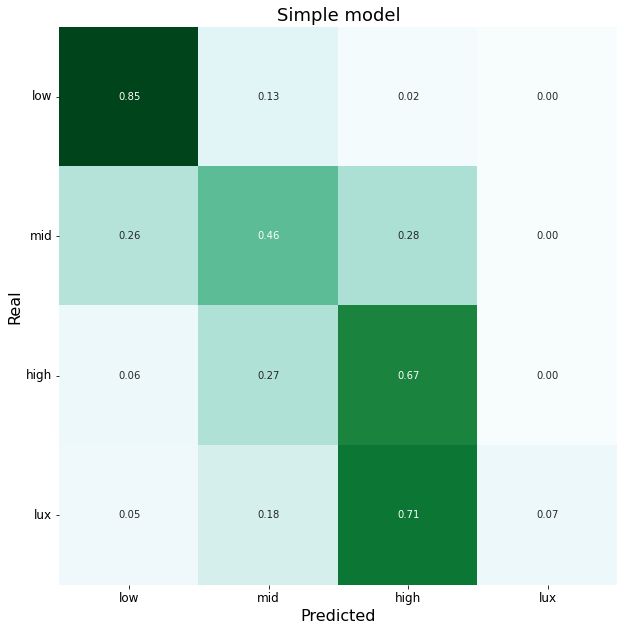

In [27]:
classes = [0, 1, 2, 3]
labels = ['low', 'mid', 'high', 'lux']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(10,510))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.title("Simple model", fontsize=18)

plt.show()

## Baseline model with class balancing

### Training

In [28]:
classes = y_train.unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{1: 0.7608836099791273,
 2: 0.8688287368062649,
 0: 0.7491192876015266,
 3: 5.00343137254902}

In [29]:
%%time
baseline_model = CatBoostClassifier(n_estimators=200,
                                    learning_rate=0.01,
                                    max_depth=4,
                                    class_weights=class_weights,
                                    cat_features=['neighbourhood','room_type'],
                                    random_state=0, verbose=False)

baseline_model = baseline_model.fit(X_train, y_train)

CPU times: user 15.7 s, sys: 181 ms, total: 15.9 s
Wall time: 4.93 s


### Evaluation

In [30]:
y_pred = baseline_model.predict(X_test)

In [31]:
accuracy_score(y_test, y_pred)

0.6000522466039707

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2526
           1       0.54      0.41      0.47      2526
           2       0.57      0.54      0.55      2230
           3       0.33      0.63      0.43       374

    accuracy                           0.60      7656
   macro avg       0.54      0.60      0.56      7656
weighted avg       0.60      0.60      0.59      7656



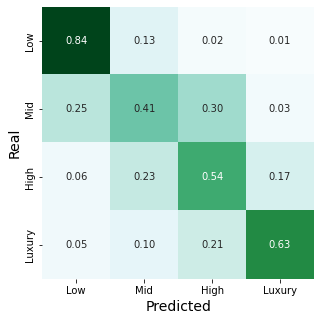

In [33]:
classes = [0, 1, 2, 3]
labels = ['Low', 'Mid', 'High', 'Luxury']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels)
plt.show()

## Cross-validation & Grid search

In [35]:
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from tqdm import tqdm

In [36]:
classes = y_train.unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{1: 0.7608836099791273,
 2: 0.8688287368062649,
 0: 0.7491192876015266,
 3: 5.00343137254902}

In [37]:
params_GridSearch = {'n_estimators': [200,600],
                     'learning_rate': [0.01,0.05,0.1],
                     'max_depth': [4,8,12],
                     'l2_leaf_reg': [1.5,3,8]}

EARLY_STOPPING_ROUNDS = 25

In [38]:
def random_forest_cross_val(X, y, params, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    acc = []
    
    for train_ind, test_ind in skf.split(X, y):
        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]
        
        X_test = X.iloc[test_ind]
        y_test = y.iloc[test_ind]
        
        X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
        
        # print(X_trn.shape, y_trn.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
        
        model = CatBoostClassifier(n_estimators=params['n_estimators'],
                                   learning_rate=params['learning_rate'],
                                   max_depth=params['max_depth'],
                                   l2_leaf_reg=params['l2_leaf_reg'],
                                   class_weights=class_weights,
                                   cat_features=['neighbourhood','room_type'],
                                   loss_function='MultiClass',
                                   eval_metric='Accuracy',
                                   thread_count=-1, random_state=42, verbose=False)
        
        model.fit(X_trn, y_trn, eval_set=(X_val, y_val), use_best_model=True, early_stopping_rounds=EARLY_STOPPING_ROUNDS)
        
        y_pred = model.predict(X_test)
        
        acc.append( accuracy_score(y_test, y_pred) )
        
    return sum(acc) / n_splits

In [39]:
def grid_search_CV(X, y, params_GridSearch):
    df_acc_by_params = pd.DataFrame(columns=list(params_GridSearch.keys()) + ['accuracy'])
        
    for prms in tqdm( list(ParameterGrid(params_GridSearch)), ascii=True, desc='Params Tuning:', position=0, leave=True ):
                          
        accuracy = random_forest_cross_val(X, y, prms, n_splits=5)
        
        data_dic = eval('{'+','.join([f"'{k}':[prms['{k}']]" for k in params_GridSearch.keys()])+'}')
        data_dic['accuracy'] = [accuracy]
        
        df_acc_by_params = pd.concat([df_acc_by_params,
                                      pd.DataFrame(data=data_dic)], 
                                      ignore_index=True)
        
    return df_acc_by_params

In [40]:
df_accuracy_by_params = grid_search_CV(X, y, params_GridSearch)

Params Tuning:: 100%|##########| 54/54 [48:23<00:00, 53.77s/it] 


In [41]:
df_accuracy_by_params['n_estimators'] = df_accuracy_by_params.n_estimators.astype(int)
df_accuracy_by_params['max_depth'] = df_accuracy_by_params.max_depth.astype(int)
df_accuracy_by_params['learning_rate'] = df_accuracy_by_params.learning_rate.astype(float)
df_accuracy_by_params['l2_leaf_reg'] = df_accuracy_by_params.l2_leaf_reg.astype(float)

In [42]:
df_accuracy_by_params.head()

,n_estimators,learning_rate,max_depth,l2_leaf_reg,accuracy
0,200,0.01,4,1.5,0.588526
1,600,0.01,4,1.5,0.589231
2,200,0.01,8,1.5,0.599786
3,600,0.01,8,1.5,0.599786
4,200,0.01,12,1.5,0.607623


In [43]:
df_accuracy_by_params.corr()['accuracy']

n_estimators     0.006482
learning_rate    0.810679
max_depth        0.458405
l2_leaf_reg     -0.089583
accuracy         1.000000
Name: accuracy, dtype: float64

In [44]:
df_accuracy_by_params.sort_values('accuracy', ascending=False).head(10)

,n_estimators,learning_rate,max_depth,l2_leaf_reg,accuracy
35,600,0.10,12,3.0,0.640254
34,200,0.10,12,3.0,0.640254
17,600,0.10,12,1.5,0.637327
16,200,0.10,12,1.5,0.637327
29,600,0.05,12,3.0,0.634324
32,200,0.10,8,3.0,0.634010
33,600,0.10,8,3.0,0.634010
15,600,0.10,8,1.5,0.633984
14,200,0.10,8,1.5,0.633879
28,200,0.05,12,3.0,0.633775


## Best model

### Training & Evaluation

In [46]:
classes = y_train.unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{1: 0.7608836099791273,
 2: 0.8688287368062649,
 0: 0.7491192876015266,
 3: 5.00343137254902}

In [51]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

model = CatBoostClassifier(n_estimators=200,
                           learning_rate=0.1,
                           max_depth=12,
                           l2_leaf_reg=1.5,
                           class_weights=class_weights,
                           cat_features=['neighbourhood','room_type'],
                           loss_function='MultiClass',
                           eval_metric='Accuracy',
                           thread_count=-1, random_state=42, verbose=True)
        
model.fit(X_trn, y_trn, eval_set=(X_val, y_val), use_best_model=True, early_stopping_rounds=25)

y_pred = model.predict(X_test)

0:	learn: 0.5738156	test: 0.5693759	best: 0.5693759 (0)	total: 110ms	remaining: 21.9s
1:	learn: 0.6026899	test: 0.5900427	best: 0.5900427 (1)	total: 425ms	remaining: 42.1s
2:	learn: 0.6191998	test: 0.6019440	best: 0.6019440 (2)	total: 637ms	remaining: 41.8s
3:	learn: 0.6232976	test: 0.6143892	best: 0.6143892 (3)	total: 856ms	remaining: 41.9s
4:	learn: 0.6277858	test: 0.6123707	best: 0.6143892 (3)	total: 1.1s	remaining: 42.8s
5:	learn: 0.6231472	test: 0.6140324	best: 0.6143892 (3)	total: 1.14s	remaining: 36.9s
6:	learn: 0.6275070	test: 0.6165801	best: 0.6165801 (6)	total: 1.4s	remaining: 38.7s
7:	learn: 0.6307360	test: 0.6183955	best: 0.6183955 (7)	total: 1.62s	remaining: 38.8s
8:	learn: 0.6324773	test: 0.6155950	best: 0.6183955 (7)	total: 1.82s	remaining: 38.7s
9:	learn: 0.6379182	test: 0.6180997	best: 0.6183955 (7)	total: 2.07s	remaining: 39.3s
10:	learn: 0.6393245	test: 0.6194330	best: 0.6194330 (10)	total: 2.29s	remaining: 39.3s
11:	learn: 0.6414901	test: 0.6183007	best: 0.6194330 (

In [52]:
accuracy_score(y_test, y_pred)

0.6400208986415883

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2526
           1       0.58      0.48      0.53      2526
           2       0.63      0.59      0.61      2230
           3       0.38      0.67      0.49       374

    accuracy                           0.64      7656
   macro avg       0.59      0.65      0.60      7656
weighted avg       0.64      0.64      0.64      7656



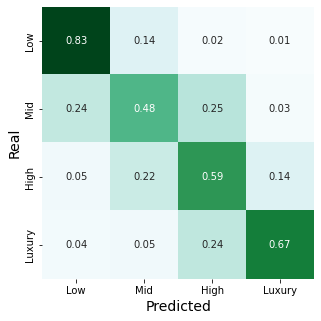

In [54]:
classes = [0, 1, 2, 3]
labels = ['Low', 'Mid', 'High', 'Luxury']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels)
plt.show()

In [55]:
model.save_model("../../models/catboost-model-depth12-iter200-l2reg1_5-lr0_1")

### Explicabilidad - Importance plot

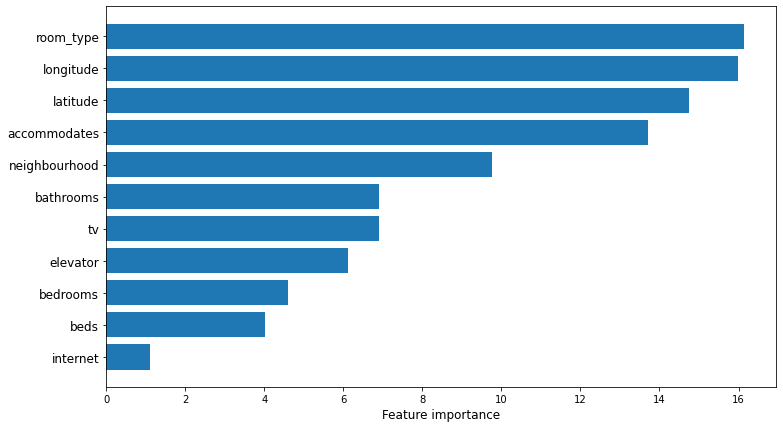

In [56]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns[indices]
importances = importances[indices]

fig, ax = plt.subplots(figsize=(12, 7))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), features, fontsize=12)
ax.invert_yaxis()
ax.set_xlabel("Feature importance", fontsize=12)

plt.show()

### Explicabilidad - Shap values

In [57]:
import shap
import pickle

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
with open("shap_values_catboost_model.pickle", "wb") as f:
    pickle.dump(shap_values, f)

In [59]:
with open("shap_values_catboost_model.pickle", "rb") as f:
    shap_values = pickle.load(f)

#### Global Shap values

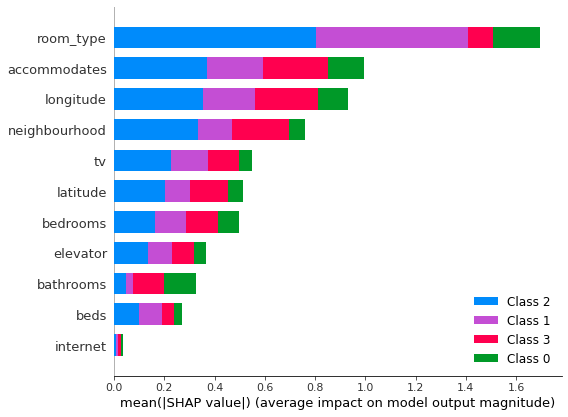

In [60]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=X_test.shape[1])

#### Shap values - class 0 (Low price)

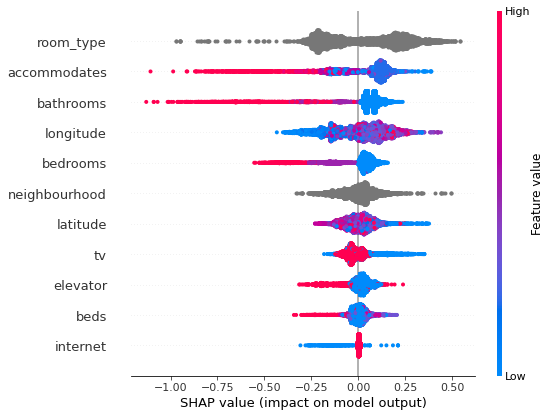

In [61]:
shap.summary_plot(shap_values[0], X_test, max_display=X_test.shape[1])

#### Shap values - class 1 (Mid price)

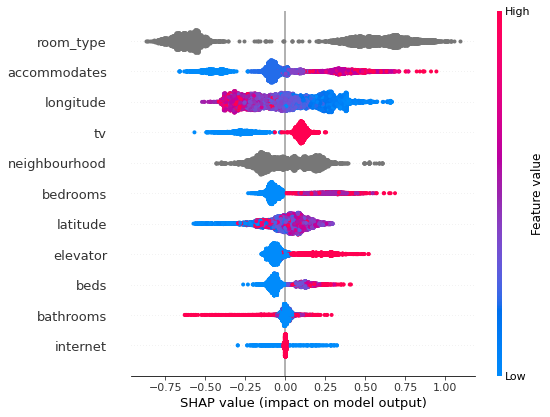

In [62]:
shap.summary_plot(shap_values[1], X_test, max_display=X_test.shape[1])

#### Shap values - class 2 (High price)

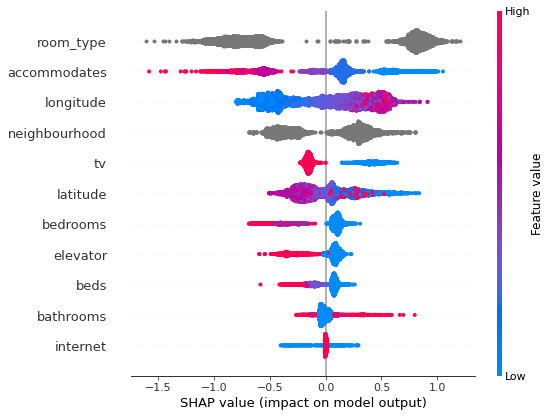

In [63]:
shap.summary_plot(shap_values[2], X_test, max_display=X_test.shape[1])

#### Shap values - class 3 (Luxury price)

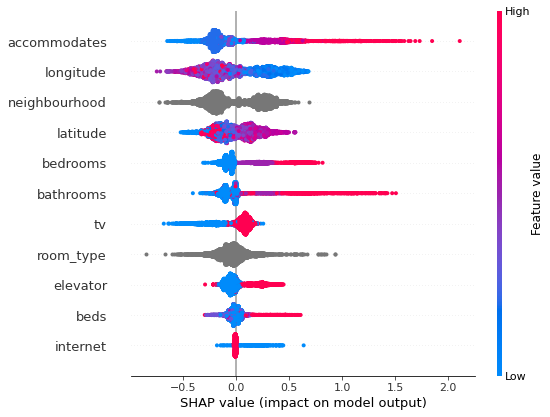

In [64]:
shap.summary_plot(shap_values[3], X_test, max_display=X_test.shape[1])

# Modeling - Logistic regression

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Additional preprocessing

In [67]:
scaler = StandardScaler()
data['latitude'] = scaler.fit_transform( data.latitude.values.reshape(-1, 1) )
data['longitude'] = scaler.fit_transform( data.longitude.values.reshape(-1, 1) )
data['accommodates'] = scaler.fit_transform( data.accommodates.values.reshape(-1, 1) )
data['bathrooms'] = scaler.fit_transform( data.bathrooms.values.reshape(-1, 1) )

In [68]:
data = pd.get_dummies(data, columns=['room_type','neighbourhood'], drop_first=True)

In [69]:
data.drop(columns=['beds','bedrooms'], inplace=True)

In [70]:
data.head()

,latitude,longitude,accommodates,price,bathrooms,tv,elevator,internet,room_type_Hotel room,room_type_Private-Share room,neighbourhood_Brooklyn,neighbourhood_Manhattan
0,0.436829,-0.721506,-0.958487,1,-0.345037,1,0,1,0,0,0,1
1,-0.793991,-0.171059,0.111197,0,-0.345037,1,0,1,0,0,1,0
2,-0.786637,-0.121216,-0.423645,0,-0.345037,0,0,1,0,1,1,0
3,-1.193801,-0.897831,0.646039,2,0.800210,1,0,1,0,0,1,0
4,0.634313,-0.673830,-0.423645,0,-0.345037,1,0,1,0,1,0,1


In [71]:
X = data.drop(columns=['price'])
y = data['price']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30621, 11), (7656, 11), (30621,), (7656,))

## Baseline model

### Training

In [61]:
classes = y_train.unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{1: 0.7608836099791273,
 2: 0.8688287368062649,
 0: 0.7491192876015266,
 3: 5.00343137254902}

In [62]:
clf = LogisticRegression(class_weight=class_weights, multi_class='multinomial', random_state=42, n_jobs=-1)
clf = clf.fit(X_train, y_train)

### Evaluation

In [63]:
y_pred = clf.predict(X_test)

In [64]:
accuracy_score(y_test, y_pred)

0.5948275862068966

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      2526
           1       0.55      0.37      0.44      2526
           2       0.57      0.56      0.56      2230
           3       0.30      0.65      0.41       374

    accuracy                           0.59      7656
   macro avg       0.53      0.61      0.55      7656
weighted avg       0.60      0.59      0.59      7656



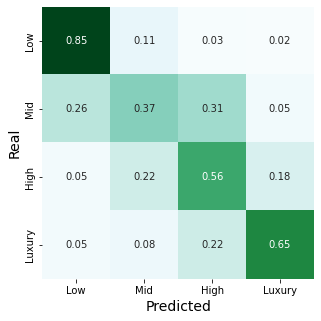

In [66]:
classes = [0, 1, 2, 3]
labels = ['Low', 'Mid', 'High', 'Luxury']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels)
plt.show()

TODO
- USE SHAP FOR EXPLAINABILITY OF BEST MODEL